In [1]:
import numpy as np
import networkx as nx
from itertools import combinations
import random
import math
import matplotlib.pyplot as plt


def generate_block_network(block_sizes, prob_matrix):
    """Generate a stochastic block model (SBM) network."""
    num_blocks = len(block_sizes)
    G = nx.Graph()
    
    # Assign blocks
    current_label = 0
    for i, size in enumerate(block_sizes):
        for _ in range(size):
            G.add_node(current_label, block=i)
            current_label += 1
    
    # Add edges based on probability matrix
    start_idx = 0
    for i in range(num_blocks):
        end_idx = start_idx + block_sizes[i]
        start_jdx = 0
        for j in range(num_blocks):
            end_jdx = start_jdx + block_sizes[j]
            for u in range(start_idx, end_idx):
                for v in range(start_jdx, end_jdx):
                    if u < v and np.random.rand() < prob_matrix[i][j]:
                        G.add_edge(u, v)
            start_jdx = end_jdx
        start_idx = end_idx
    
    return G


def modify_network(G, modification_fraction):
    """Randomly remove and add links to create the observed network A_O."""
    G_modified = G.copy()
    edges = list(G.edges())
    nodes = list(G.nodes())
    num_to_modify = int(len(edges) * modification_fraction)
    
    removed_edges = []
    added_edges = []
    
    # Remove edges
    edges_to_remove = np.random.choice(len(edges), num_to_modify // 2, replace=False)
    for idx in edges_to_remove:
        removed_edges.append(edges[idx])
        G_modified.remove_edge(*edges[idx])
    
    # Add edges
    for _ in range(num_to_modify // 2):
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G_modified.has_edge(u, v) and u != v:
            G_modified.add_edge(u, v)
            added_edges.append((u, v))
    
    return G_modified, removed_edges, added_edges


def initialize_partition(G):
    """Initialize random partitions (each node is its own group)."""
    return {node: node for node in G.nodes()}


def calculate_H(P, G):
    """Compute H(P) based on partition P."""
    if not P or not G:  # Handle empty inputs
        return 0

    block_counts = {}
    for node, group in P.items():
        block_counts.setdefault(group, []).append(node)

    lO = {}
    r = {}

    # Count links in the observed network
    for u, v in G.edges():
        gu, gv = P[u], P[v]
        key = tuple(sorted([gu, gv]))
        lO[key] = lO.get(key, 0) + 1

    # Compute rαβ (max possible links between groups)
    for (g1, nodes1), (g2, nodes2) in combinations(block_counts.items(), 2):
        key = tuple(sorted([g1, g2]))
        r[key] = len(nodes1) * len(nodes2)

    # Handle self-links within the same group
    for g, nodes in block_counts.items():
        key = (g, g)
        r[key] = len(nodes) * (len(nodes) - 1) // 2

    # Compute H(P)
    H = sum(
        math.log(float(r[key] + 1)) +
        math.log(math.comb(r[key], lO.get(key, 0)))
        for key in r if r[key] > 0
    )

    return H


def metropolis_MCMC(G, num_samples):
    """Run MCMC sampling to estimate the partition distribution."""
    P = initialize_partition(G)
    partitions = []

    if not P or not G:
        raise ValueError("Partition or graph must not be empty.")

    for _ in range(num_samples):
        node = random.choice(list(G.nodes()))
        new_group = random.choice(list(P.values()))  # Move node to a random group

        # Compute ΔH
        old_H = calculate_H(P, G)
        original_group = P[node]
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H

        # Accept move with probability exp(-ΔH)
        if delta_H > 0 and np.random.rand() >= np.exp(-delta_H):
            P[node] = original_group  # Reject the move

        partitions.append(P.copy())

    return partitions


def estimate_link_reliability(G, partitions):
    """Compute R_L(i,j) for all possible links based on sampled partitions."""
    if not G or not partitions:
        raise ValueError("Graph G and partitions cannot be empty.")
    
    nodes = list(G.nodes())
    reliability = {}
    node_pair_agreement = {}

    # Precompute agreement counts for all node pairs
    for p in partitions:
        for u, v in combinations(nodes, 2):  # Consider all possible node pairs
            if p[u] == p[v]:
                node_pair_agreement[(u, v)] = node_pair_agreement.get((u, v), 0) + 1

    # Compute reliability for all possible links
    for u, v in combinations(nodes, 2):  # Iterate over all possible links
        lO = node_pair_agreement.get((u, v), 0)  # Times nodes are in the same group
        r = len(partitions)
        reliability[(u, v)] = (lO + 1) / (r + 2)  # Laplace smoothing

    return reliability

# Generate True Network (A_T)
block_sizes = [4, 4, 4]  # Three groups of 10 nodes each
prob_matrix = [[0.8, 0.2, 0.1], [0.2, 0.7, 0.15], [0.1, 0.15, 0.9]]
true_network = generate_block_network(block_sizes, prob_matrix)

# Create Observed Network (A_O)
observed_network, removed_edges, added_edges = modify_network(true_network, modification_fraction=0.2)

# Run MCMC Sampling
partitions = metropolis_MCMC(observed_network, num_samples=1000)

# Estimate Link Reliability
reliability = estimate_link_reliability(observed_network, partitions)

# Print all reliable links
print("Reliable Links and Their Scores:")
for edge, rl in sorted(reliability.items(), key=lambda x: x[1], reverse=True):
    print(f"Edge {edge}: Reliability {rl:.4f}")



Reliable Links and Their Scores:
Edge (1, 2): Reliability 0.9800
Edge (5, 11): Reliability 0.9731
Edge (9, 10): Reliability 0.9611
Edge (4, 8): Reliability 0.9571
Edge (8, 11): Reliability 0.9531
Edge (0, 2): Reliability 0.9501
Edge (0, 1): Reliability 0.9481
Edge (5, 9): Reliability 0.9401
Edge (5, 8): Reliability 0.9391
Edge (4, 11): Reliability 0.9331
Edge (9, 11): Reliability 0.9321
Edge (4, 5): Reliability 0.9251
Edge (8, 10): Reliability 0.9222
Edge (7, 8): Reliability 0.9202
Edge (5, 7): Reliability 0.9182
Edge (5, 10): Reliability 0.9142
Edge (7, 11): Reliability 0.9102
Edge (4, 10): Reliability 0.9082
Edge (7, 9): Reliability 0.9082
Edge (8, 9): Reliability 0.9082
Edge (10, 11): Reliability 0.9062
Edge (7, 10): Reliability 0.9042
Edge (4, 7): Reliability 0.8962
Edge (6, 11): Reliability 0.8962
Edge (4, 9): Reliability 0.8942
Edge (2, 3): Reliability 0.8932
Edge (1, 3): Reliability 0.8912
Edge (6, 7): Reliability 0.8912
Edge (5, 6): Reliability 0.8892
Edge (6, 8): Reliability 0

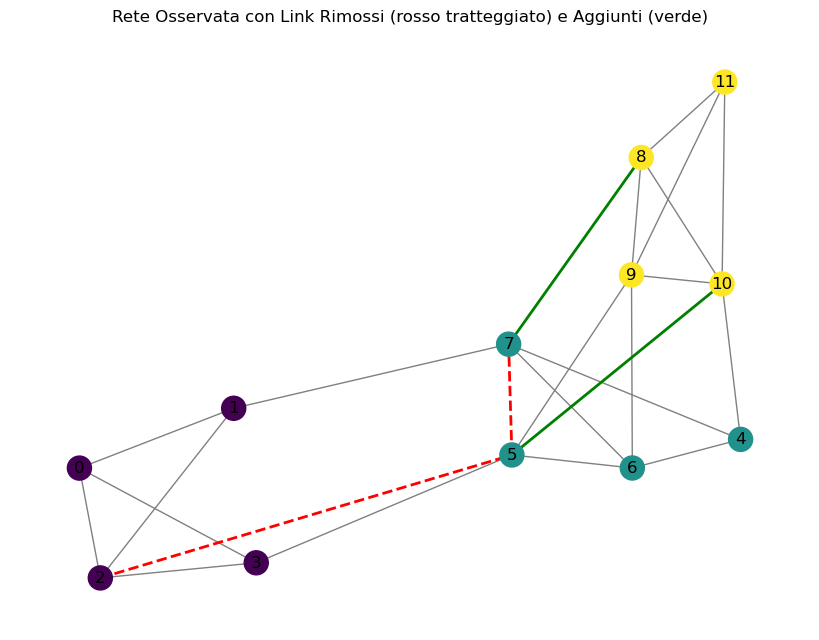

In [2]:
def plot_modified_network(G, removed_edges, added_edges):
    """Plotta la rete osservata con rimozioni e aggiunte evidenziate."""
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color=[G.nodes[n]['block'] for n in G.nodes()], edge_color='gray')
    nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color='red', style='dashed', width=2)
    nx.draw_networkx_edges(G, pos, edgelist=added_edges, edge_color='green', style='solid', width=2)
    plt.title("Rete Osservata con Link Rimossi (rosso tratteggiato) e Aggiunti (verde)")
    plt.show()

plot_modified_network(observed_network, removed_edges, added_edges)

In [3]:
def calculate_accuracy(true_network, observed_network, reliability):
    """Calculate accuracy for missing and spurious interactions based on ranking comparisons."""
    
    # Identify edge sets
    true_negatives = set(observed_network.edges()) - set(true_network.edges())  # AO_ij = 0, AT_ij = 0
    false_negatives = set(true_network.edges()) - set(observed_network.edges())  # AO_ij = 0, AT_ij = 1
    true_positives = set(observed_network.edges()) & set(true_network.edges())  # AO_ij = 1, AT_ij = 1
    false_positives = set(observed_network.edges()) - set(true_network.edges())  # AO_ij = 1, AT_ij = 0

    # Rank edges by reliability (higher reliability = higher rank)
    ranked_edges = sorted(reliability.items(), key=lambda x: x[1], reverse=True)
    edge_ranks = {edge: rank for rank, (edge, _) in enumerate(ranked_edges)}

    # Compute missing interaction accuracy: P(FN rank > TN rank)
    if false_negatives and true_negatives:
        count_correct = sum(1 for fn in false_negatives for tn in true_negatives if edge_ranks[fn] < edge_ranks[tn])
        missing_accuracy = count_correct / (len(false_negatives) * len(true_negatives))
    else:
        missing_accuracy = 1  # Undefined case when there are no FN or TN

    # Compute spurious interaction accuracy: P(FP rank < TP rank)
    if false_positives and true_positives:
        count_correct = sum(1 for fp in false_positives for tp in true_positives if edge_ranks[fp] > edge_ranks[tp])
        spurious_accuracy = count_correct / (len(false_positives) * len(true_positives))
    else:
        spurious_accuracy = 1  # Undefined case when there are no FP or TP

    return missing_accuracy, spurious_accuracy

# Calculate Accuracy
missing_accuracy, spurious_accuracy = calculate_accuracy(true_network, observed_network, reliability)

# Print Results
print(f"Missing Interaction Accuracy: {missing_accuracy:.4f}")
print(f"Spurious Interaction Accuracy: {spurious_accuracy:.4f}")


Missing Interaction Accuracy: 0.2500
Spurious Interaction Accuracy: 0.4000


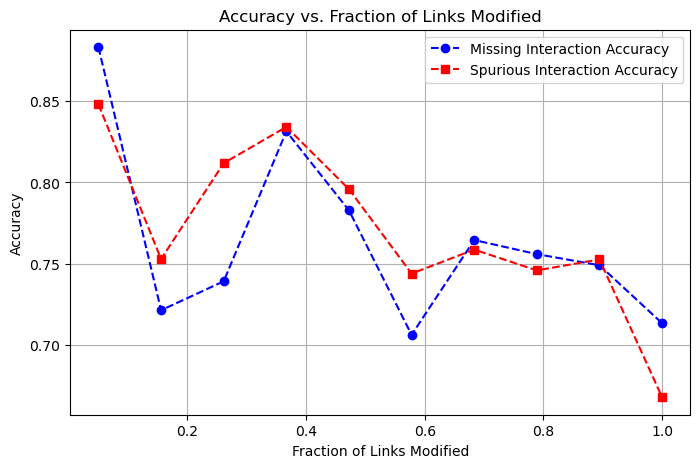

In [12]:
# Define the range of fractions to test
fractions = np.linspace(0.05, 1.0, 10)  # From 5% to 50% in 10 steps

# Store results
missing_accuracies = []
spurious_accuracies = []

# Generate True Network (A_T)
block_sizes = [20, 18, 22]  # Three groups of 4 nodes each
prob_matrix = [[0.8, 0.2, 0.1], [0.2, 0.7, 0.15], [0.1, 0.15, 0.9]]
true_network = generate_block_network(block_sizes, prob_matrix)

for fraction in fractions:
    # Modify network by removing and adding different fractions of links
    observed_network, removed_edges, added_edges = modify_network(true_network, modification_fraction=fraction)

    # Run MCMC Sampling
    partitions = metropolis_MCMC(observed_network, num_samples=10000)

    # Estimate Link Reliability
    reliability = estimate_link_reliability(observed_network, partitions)

    # Calculate Accuracy
    missing_accuracy, spurious_accuracy = calculate_accuracy(true_network, observed_network, reliability)

    # Store results
    missing_accuracies.append(missing_accuracy)
    spurious_accuracies.append(spurious_accuracy)

# Plot Accuracy vs. Fraction of Links Modified
plt.figure(figsize=(8, 5))
plt.plot(fractions, missing_accuracies, label="Missing Interaction Accuracy", marker="o", linestyle="--", color="blue")
plt.plot(fractions, spurious_accuracies, label="Spurious Interaction Accuracy", marker="s", linestyle="--", color="red")

plt.xlabel("Fraction of Links Modified")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Fraction of Links Modified")
plt.legend()
plt.grid()
plt.show()
